# **Preprocessing of the LandCover.ai Dataset**

The [LandCover.ai (Land Cover from Aerial Imagery)](https://arxiv.org/pdf/2005.02264v4) dataset consists of aerial images of rural areas in Poland, captured under various optical conditions and during different periods of the vegetation season. It includes 41 orthophoto mosaics from different counties across all regions of the country. These orthophotos are divided into 512×512 pixel tiles, resulting in a total of 7,470 images with corresponding segmentation masks for training, 1,602 for validation and 1,602 for testing. The segmentation masks include the following classes: **background (0)**, **building (1)**, **woodland (2)**, **water (3)**, and **road (4)**.

## **Imports**

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from google.colab import drive
import cv2
import os

## **Parameters**

In [4]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
dataset_url = "https://landcover.ai.linuxpolska.com/download/landcover.ai.v1.zip"
dataset_dir = "/content/LandCover.ai"
zip_dataset_path = "/content/drive/MyDrive/Datasets/LandCover.ai.zip"

os.makedirs(dataset_dir, exist_ok=True)

## **Download and Extract the Dataset**

In [ ]:
raw_dataset_dir = tf.keras.utils.get_file(
    origin=dataset_url,
    cache_dir=os.getcwd(),
    extract=True
)
raw_dataset_dir = os.path.dirname(raw_dataset_dir)
raw_dataset_dir

1538212277/1538212277 ━━━━━━━━━━━━━━━━━━━━ 91s 0us/step


'/content/datasets'

## **Preprocess the Dataset**


The preprocessing of the dataset is already set up upon extracting it and is implemented in the `split.py` file. Only minor adjustments to the image and mask paths are required, as shown below:

```
#!/usr/bin/env python3
import glob
import os
import cv2

RAW_IMGS_DIR = "./datasets/images"
RAW_MASKS_DIR = "./datasets/masks"

OUTPUT_DIR = "./LandCover.ai"
IMGS_DIR = os.path.join(OUTPUT_DIR, "images")
MASKS_DIR = os.path.join(OUTPUT_DIR, "masks")

os.makedirs(IMGS_DIR, exist_ok=True)
os.makedirs(MASKS_DIR, exist_ok=True)

TARGET_SIZE = 512

img_paths = glob.glob(os.path.join(RAW_IMGS_DIR, "*.tif"))
mask_paths = glob.glob(os.path.join(RAW_MASKS_DIR, "*.tif"))

img_paths.sort()
mask_paths.sort()

os.makedirs(OUTPUT_DIR, exist_ok=True)
for i, (img_path, mask_path) in enumerate(zip(img_paths, mask_paths)):
    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    mask_filename = os.path.splitext(os.path.basename(mask_path))[0]
    
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    assert img_filename == mask_filename and img.shape[:2] == mask.shape[:2]

    k = 0
    for y in range(0, img.shape[0], TARGET_SIZE):
        for x in range(0, img.shape[1], TARGET_SIZE):
            img_tile = img[y:y + TARGET_SIZE, x:x + TARGET_SIZE]
            mask_tile = mask[y:y + TARGET_SIZE, x:x + TARGET_SIZE]

            if img_tile.shape[0] == TARGET_SIZE and img_tile.shape[1] == TARGET_SIZE:
                out_img_path = os.path.join(IMGS_DIR, "{}_{}.jpg".format(img_filename, k))
                cv2.imwrite(out_img_path, img_tile)

                out_mask_path = os.path.join(MASKS_DIR, "{}_{}.png".format(mask_filename, k))
                cv2.imwrite(out_mask_path, mask_tile)

            k += 1

    print("Processed {} {}/{}".format(img_filename, i + 1, len(img_paths)))
```

In [ ]:
# View the number of orthophotos
print(
    len(os.listdir(os.path.join(raw_dataset_dir,"images"))),
    len(os.listdir(os.path.join(raw_dataset_dir,"masks")))
)

41 41


In [ ]:
# Run the 'split.py' file
!python3 {os.path.join(raw_dataset_dir, "split.py")}

Processed M-33-20-D-c-4-2 1/41
Processed M-33-20-D-d-3-3 2/41
Processed M-33-32-B-b-4-4 3/41
Processed M-33-48-A-c-4-4 4/41
Processed M-33-7-A-d-2-3 5/41
Processed M-33-7-A-d-3-2 6/41
Processed M-34-32-B-a-4-3 7/41
Processed M-34-32-B-b-1-3 8/41
Processed M-34-5-D-d-4-2 9/41
Processed M-34-51-C-b-2-1 10/41
Processed M-34-51-C-d-4-1 11/41
Processed M-34-55-B-b-4-1 12/41
Processed M-34-56-A-b-1-4 13/41
Processed M-34-6-A-d-2-2 14/41
Processed M-34-65-D-a-4-4 15/41
Processed M-34-65-D-c-4-2 16/41
Processed M-34-65-D-d-4-1 17/41
Processed M-34-68-B-a-1-3 18/41
Processed M-34-77-B-c-2-3 19/41
Processed N-33-104-A-c-1-1 20/41
Processed N-33-119-C-c-3-3 21/41
Processed N-33-130-A-d-3-3 22/41
Processed N-33-130-A-d-4-4 23/41
Processed N-33-139-C-d-2-2 24/41
Processed N-33-139-C-d-2-4 25/41
Processed N-33-139-D-c-1-3 26/41
Processed N-33-60-D-c-4-2 27/41
Processed N-33-60-D-d-1-2 28/41
Processed N-33-96-D-d-1-1 29/41
Processed N-34-106-A-b-3-4 30/41
Processed N-34-106-A-c-1-3 31/41
Processed N-

In [ ]:
# Copy the 'split.py' file to the dataset directory (optional)
!cp -r {os.path.join(raw_dataset_dir, "split.py")} {os.path.join(dataset_dir, "split.py")}

In [ ]:
# Create a DataFrame with the paths of the images and masks

df_data = pd.concat([
    pd.read_csv(os.path.join(raw_dataset_dir, "train.txt"), header=None, names=["filename"]).assign(split="train"),
    pd.read_csv(os.path.join(raw_dataset_dir, "val.txt"), header=None, names=["filename"]).assign(split="val"),
    pd.read_csv(os.path.join(raw_dataset_dir, "test.txt"), header=None, names=["filename"]).assign(split="test")
])

df_data["image_path"] = df_data.filename.apply(lambda x: os.path.join(dataset_dir, f"images/{x}.jpg"))
df_data["mask_path"] = df_data.filename.apply(lambda x: os.path.join(dataset_dir, f"masks/{x}.png"))

df_data = df_data.reset_index(drop=True)
df_data

,filename,split,image_path,mask_path
0,M-33-20-D-c-4-2_0,train,/content/LandCover.ai/images/M-33-20-D-c-4-2_0...,/content/LandCover.ai/masks/M-33-20-D-c-4-2_0.png
1,M-33-20-D-c-4-2_1,train,/content/LandCover.ai/images/M-33-20-D-c-4-2_1...,/content/LandCover.ai/masks/M-33-20-D-c-4-2_1.png
2,M-33-20-D-c-4-2_10,train,/content/LandCover.ai/images/M-33-20-D-c-4-2_1...,/content/LandCover.ai/masks/M-33-20-D-c-4-2_10...
3,M-33-20-D-c-4-2_100,train,/content/LandCover.ai/images/M-33-20-D-c-4-2_1...,/content/LandCover.ai/masks/M-33-20-D-c-4-2_10...
4,M-33-20-D-c-4-2_102,train,/content/LandCover.ai/images/M-33-20-D-c-4-2_1...,/content/LandCover.ai/masks/M-33-20-D-c-4-2_10...
...,...,...,...,...
10669,N-34-97-D-c-2-4_63,test,/content/LandCover.ai/images/N-34-97-D-c-2-4_6...,/content/LandCover.ai/masks/N-34-97-D-c-2-4_63...
10670,N-34-97-D-c-2-4_66,test,/content/LandCover.ai/images/N-34-97-D-c-2-4_6...,/content/LandCover.ai/masks/N-34-97-D-c-2-4_66...
10671,N-34-97-D-c-2-4_74,test,/content/LandCover.ai/images/N-34-97-D-c-2-4_7...,/content/LandCover.ai/masks/N-34-97-D-c-2-4_74...
10672,N-34-97-D-c-2-4_76,test,/content/LandCover.ai/images/N-34-97-D-c-2-4_7...,/content/LandCover.ai/masks/N-34-97-D-c-2-4_76...


In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10674 entries, 0 to 10673
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    10674 non-null  object
 1   split       10674 non-null  object
 2   image_path  10674 non-null  object
 3   mask_path   10674 non-null  object
dtypes: object(4)
memory usage: 333.7+ KB


In [ ]:
# View the number of records for each dataset
df_data.split.value_counts()

,count
split,
train,7470
val,1602
test,1602


In [ ]:
# Define the classes and their respective colors
classes = {
    "background": [0, 0, 0],
    "building": [102, 51, 0],
    "woodland": [34, 139, 34],
    "water": [50, 150, 255],
    "road": [128, 128, 0]
}

In [ ]:
# Save the DataFrame with the metadata
df_data.to_csv(os.path.join(dataset_dir, "metadata.csv"), index=False)

# Save the classes DataFrame
pd.DataFrame(classes.items(), columns=["name", "color"]).to_csv(
    os.path.join(dataset_dir, "classes.csv"), index=False
)

In [ ]:
# Compress the dataset into a zip file and save it
!zip -r $zip_dataset_path {os.path.basename(dataset_dir)} -q

## **Visualization Example**

In [ ]:
# Function to plot images with their segmentation masks
def plot_image_masks(df, n_rows=3, alpha=0.5, random=True):
  class_colors = np.array(list(classes.values()))
  background_class = list(classes.keys()).index("background")

  image_paths = df.image_path.values
  mask_paths = df.mask_path.values

  indices = np.arange(len(image_paths))
  if random:
    np.random.shuffle(indices)

  fig, ax = plt.subplots(n_rows, 3, figsize=(3.5 * 3, 3.5 * n_rows))
  ax[0, 0].set_title("Image", fontsize=10)
  ax[0, 1].set_title("Mask", fontsize=10)
  ax[0, 2].set_title("Blended Image", fontsize=10)

  for i in range(n_rows):
    idx = indices[i]
    image = np.array(Image.open(image_paths[idx]).convert("RGB"))
    mask_cls = np.array(Image.open(mask_paths[idx]))
    mask_rgb = class_colors[mask_cls]

    mask_rgb[mask_cls == background_class] = image[mask_cls == background_class]
    blended_image = cv2.addWeighted(image / 255, 1 - alpha, mask_rgb / 255, alpha, 0)

    ax[i, 0].imshow(image)
    ax[i, 1].imshow(class_colors[mask_cls])
    ax[i, 2].imshow(blended_image)

    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")

  plt.tight_layout()
  plt.show()

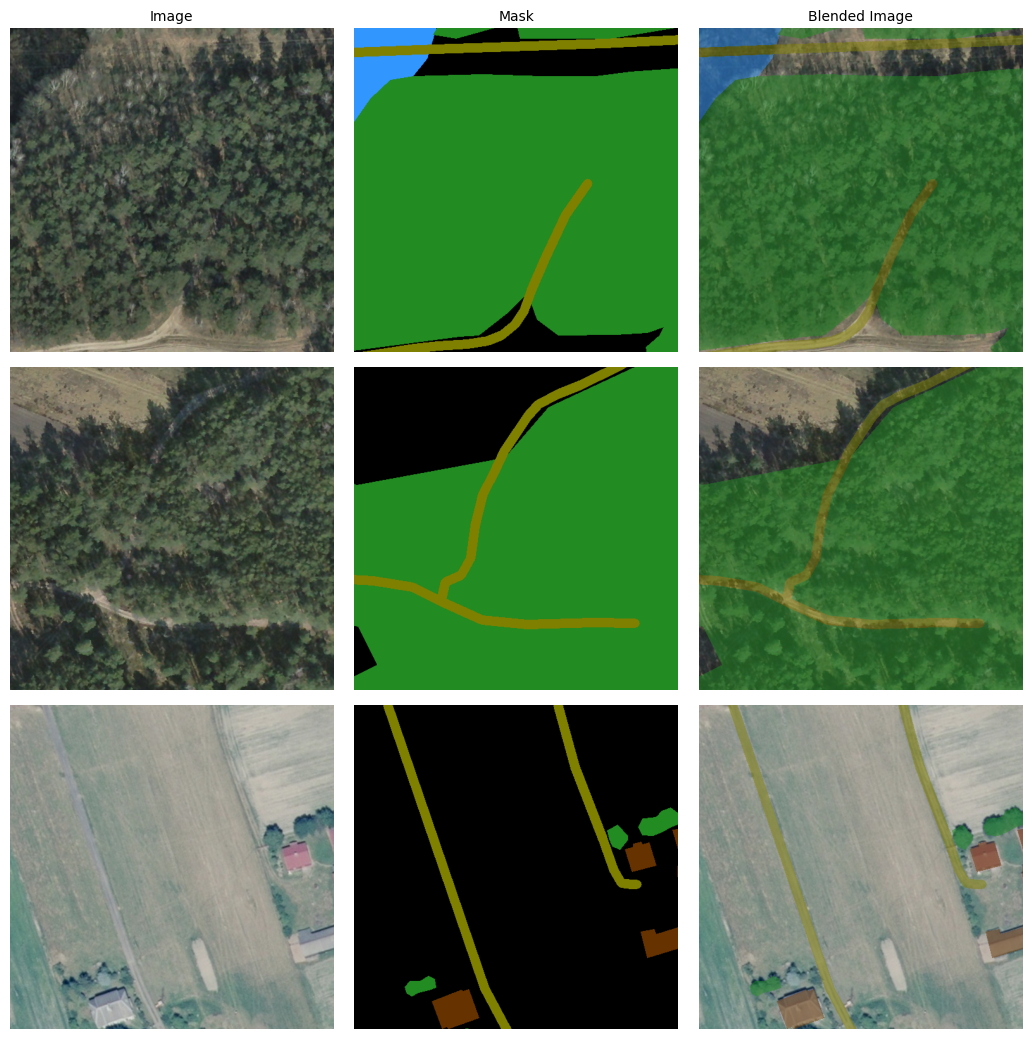

In [ ]:
plot_image_masks(df_data[df_data.split == "train"])